In [14]:
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch

M1 = False

if M1:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib.ticker as tick

import scipy as sp
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor

True
1
0
NVIDIA A100-PCIE-40GB


In [15]:
# Save param
repo_dir = "./../.."


new_wav_reg_strength = True
save_results = False

if new_wav_reg_strength:
    # New wavelet reg strength
    save_dir = "/disk/xray0/tl3/repos/QuantifAI/dev/tmp_results/hypothesis_test_paper_figs/"
    load_var_dir = "/disk/xray99/tl3/proj-convex-UQ/outputs/new_UQ_results/base_sara_wavelets/vars/"
else:
    # Original wavelet reg strength
    save_dir = "/disk/xray0/tl3/outputs/large-scale-UQ/def_UQ_results/v2/wavelets/hypothesis_test_paper_figs/"
    load_var_dir = (
        "/disk/xray99/tl3/proj-convex-UQ/outputs/new_UQ_results/wavelets/vars/"
    )


# Confidence value
alpha_prob = 0.01
# Blurring Gaussian St Dev
G_sigma = 3.5  # 1.02

# Inpatinting params
inptaint_options = {
    "tol": 5e-6,
    "iter": 15000,
    "update_iter": 4999,
    "record_iters": False,
}

map_potential_list = []
likelihood_map_potential_list = []
prior_map_potential_list = []
surrogate_potential_list = []
likelihood_surrogate_potential_list = []
prior_surrogate_potential_list = []
gamma_alpha_list = []
Hnot_reject_list = []
potential_blurring_list = []
Hnot_reject_blurring_list = []


cmap = "cubehelix"
model_prefix = "-WAV"
input_snr = 30.0
cbar_font_size = 18


if new_wav_reg_strength:
    # Wavelet parameters
    reg_param = 1e2  #
    wavs_list = ["db1", "db2", "db3", "db4", "db5", "db6", "db7", "db8", "self"] # ["db8"]
    levels = 4
    # New wavelet reg strength
    map_vars_path_arr = [
        load_var_dir + "CYN_wavelets_UQ_MAP_reg_param_1.0e+02_MAP_vars.npy",
        load_var_dir + "M31_wavelets_UQ_MAP_reg_param_1.0e+02_MAP_vars.npy",
        load_var_dir + "3c288_wavelets_UQ_MAP_reg_param_1.0e+02_MAP_vars.npy",
        load_var_dir + "3c288_wavelets_UQ_MAP_reg_param_1.0e+02_MAP_vars.npy",
        load_var_dir + "W28_wavelets_UQ_MAP_reg_param_1.0e+02_MAP_vars.npy",
    ]
    samp_vars_path_arr = [
        load_var_dir
        + "CYN_SKROCK_wavelets_reg_param_1.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "M31_SKROCK_wavelets_reg_param_1.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "3c288_SKROCK_wavelets_reg_param_1.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "3c288_SKROCK_wavelets_reg_param_1.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "W28_SKROCK_wavelets_reg_param_1.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
    ]
else:
    # Wavelet parameters
    reg_param = 5e2  #
    wavs_list = ["db8"]
    levels = 4
    # Original wavelet reg strength
    map_vars_path_arr = [
        load_var_dir + "CYN_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy",
        load_var_dir + "M31_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy",
        load_var_dir + "3c288_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy",
        load_var_dir + "3c288_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy",
        load_var_dir + "W28_wavelets_UQ_MAP_reg_param_5.0e+02_MAP_vars.npy",
    ]
    samp_vars_path_arr = [
        load_var_dir
        + "CYN_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "M31_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "3c288_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "3c288_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
        load_var_dir
        + "W28_SKROCK_wavelets_reg_param_5.0e+02_nsamples_5.0e+04_thinning_1.0e+01_vars.npy",
    ]

img_name_list = ["CYN", "M31", "3c288", "3c288", "W28"]
pysiscal_list = [True, True, True, False, True]
vmin_log_arr = [-3.0, -2.0, -2.0, -2.0, -2.0]
text_str_arr = [r"$1$", r"$1$", r"$1$", r"$2$", r"$1$"]
saving_text_str_arr = ["1", "1", "1", "2", "1"]
text_pos_arr = [
    [0, 0.12],
    [0, 0.06],
    [0, 0.06],
    [-0.05, -0.01],
    [0, 0.06],
]



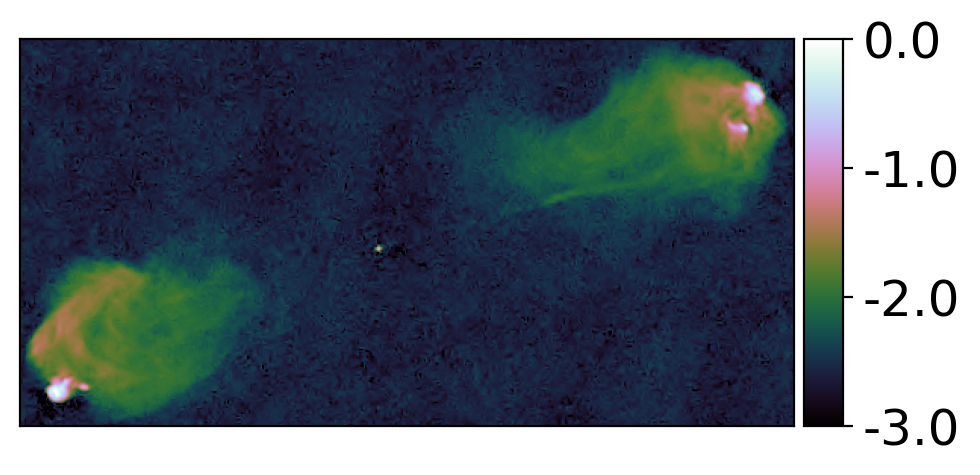

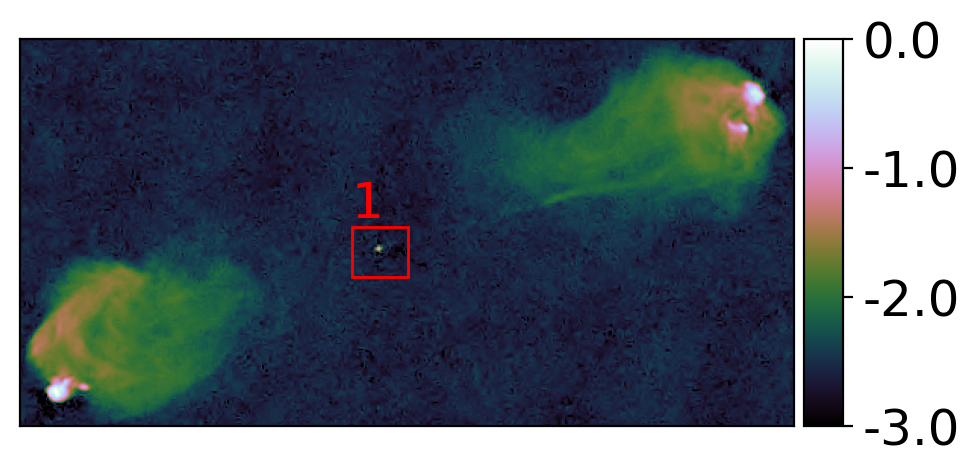

[GD] 0 out of 15000 iterations, tol = 0.000051
[GD] converged in 265 iterations


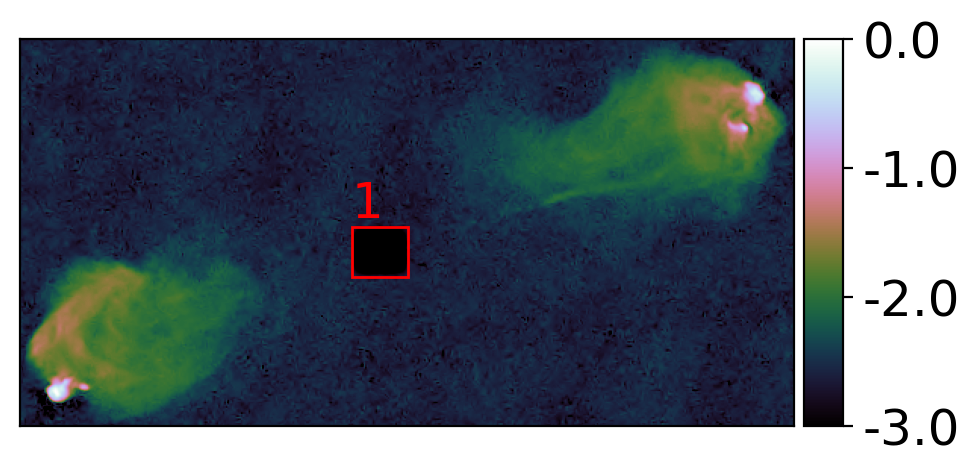

gamma_alpha:  187332.19378672657
fun(x_map).item():  52801.62488842625
tau_alpha*np.sqrt(N) + N:  134530.56889830032
CYN : Inpainted area removable! (Cannot reject H0)
CYN _gamma_alpha:  187332.19378672657
CYN _potential:  60361.22649484314
CYN -MAP_potential:  52801.62488842625
CYN : Blurred structure is physical! (Reject H0)
CYN _gamma_alpha:  187332.19378672657
CYN _potential_blurring:  998537.2603444463
CYN -MAP_potential:  52801.62488842625


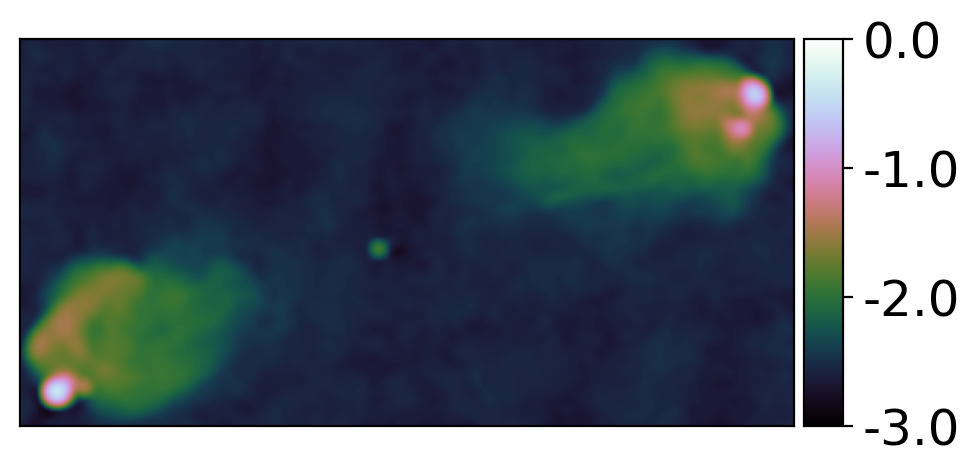

INSTRUME                                                                         [astropy.io.fits.card]


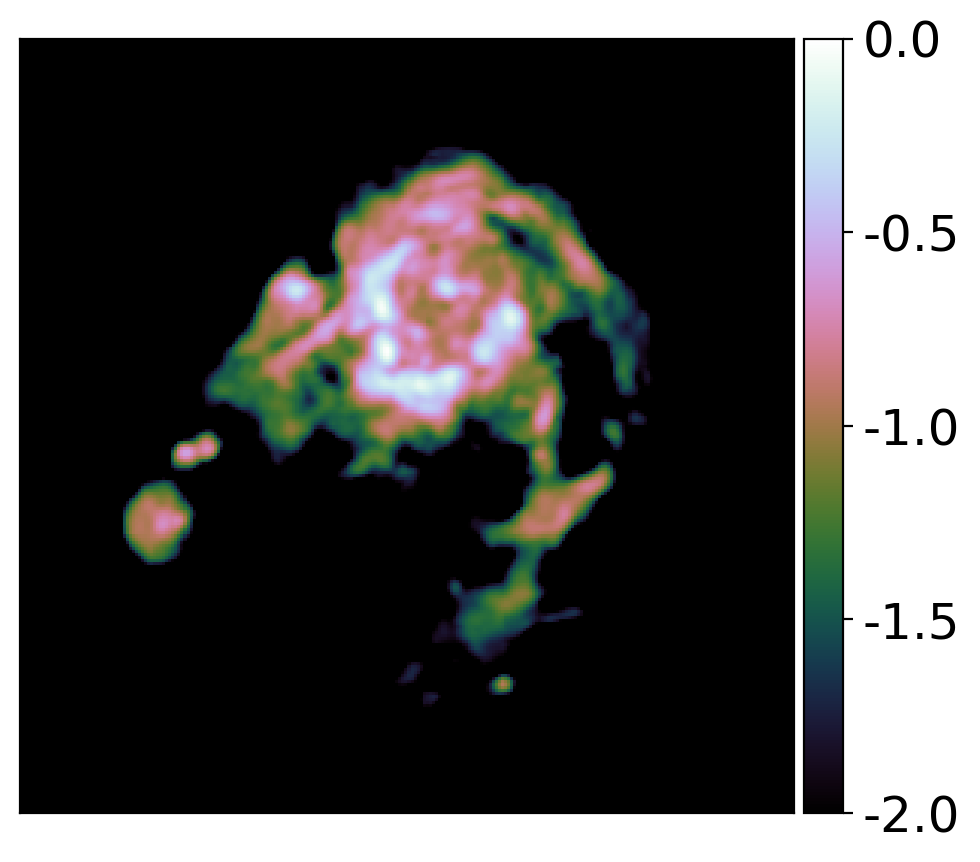

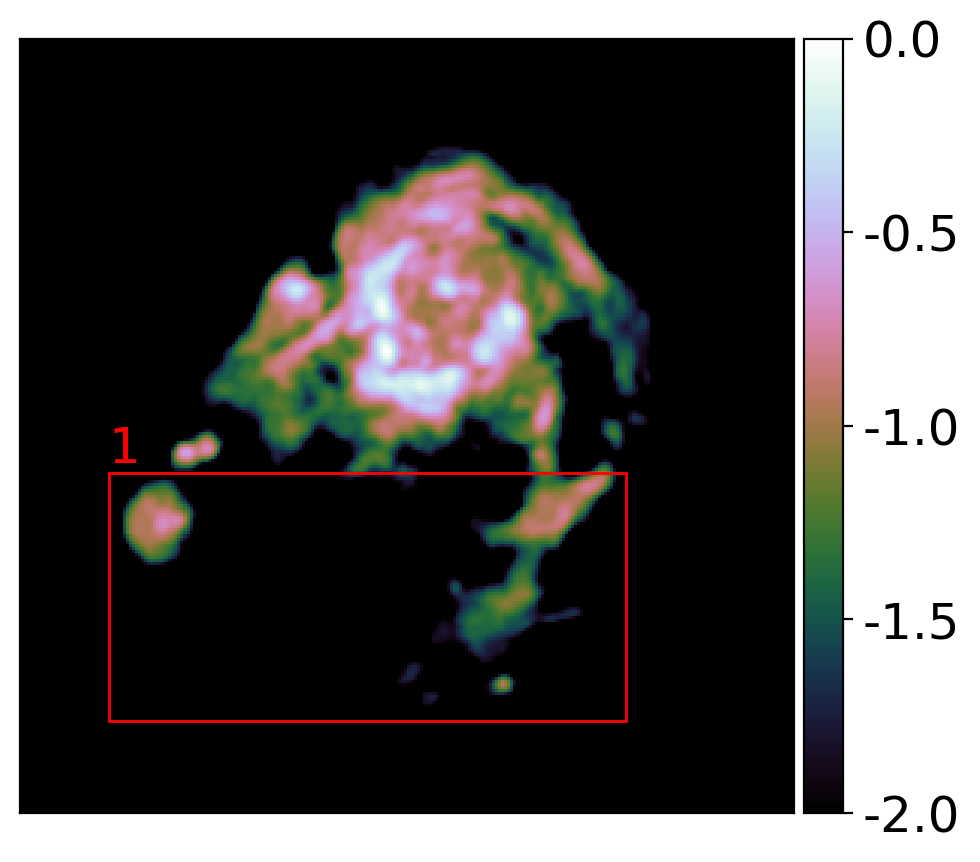

[GD] 0 out of 15000 iterations, tol = 0.000291
[GD] converged in 204 iterations


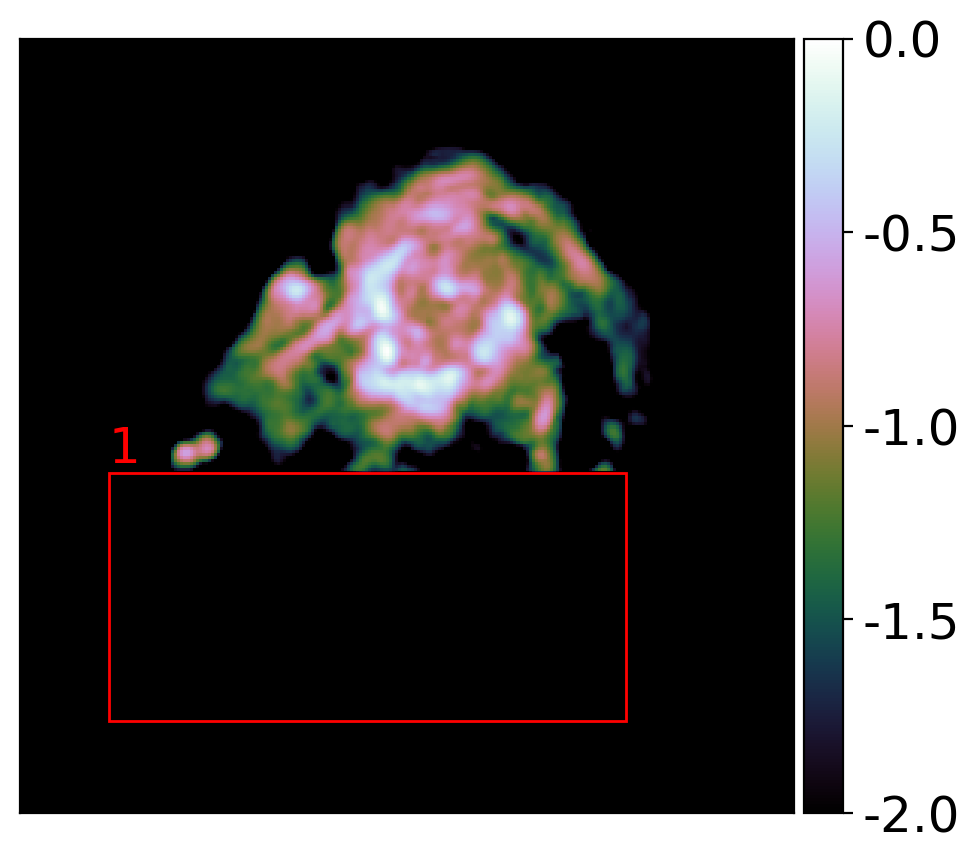

gamma_alpha:  154642.33882755088
fun(x_map).item():  86660.76130636183
tau_alpha*np.sqrt(N) + N:  67981.57752118903
M31 : Inpainted area nonremovable! (Reject H0)
M31 _gamma_alpha:  154642.33882755088
M31 _potential:  168618.1284130687
M31 -MAP_potential:  86660.76130636183
M31 : Blurred structure is physical! (Reject H0)
M31 _gamma_alpha:  154642.33882755088
M31 _potential_blurring:  238061.56632491664
M31 -MAP_potential:  86660.76130636183


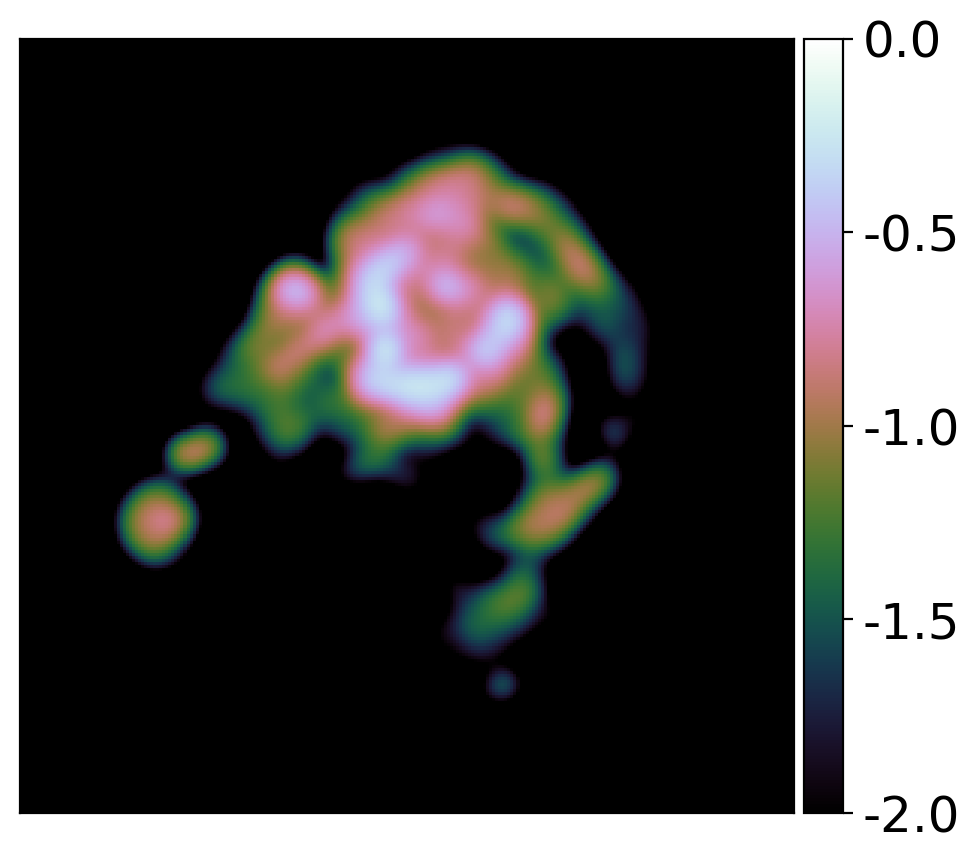

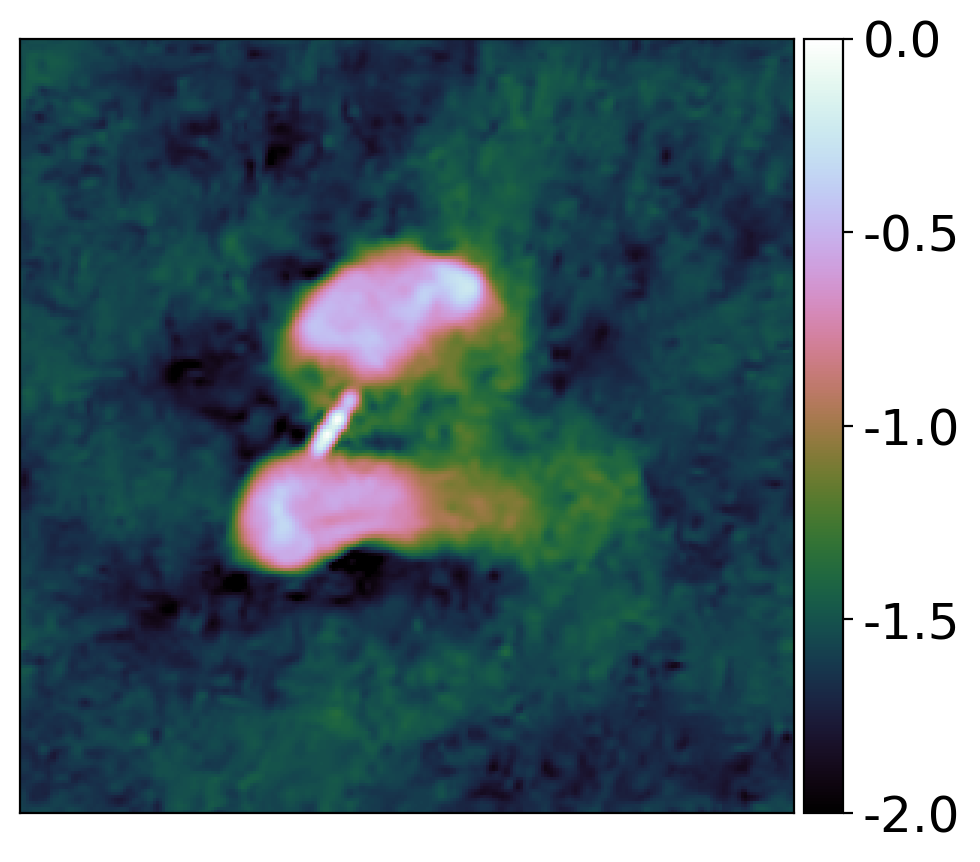

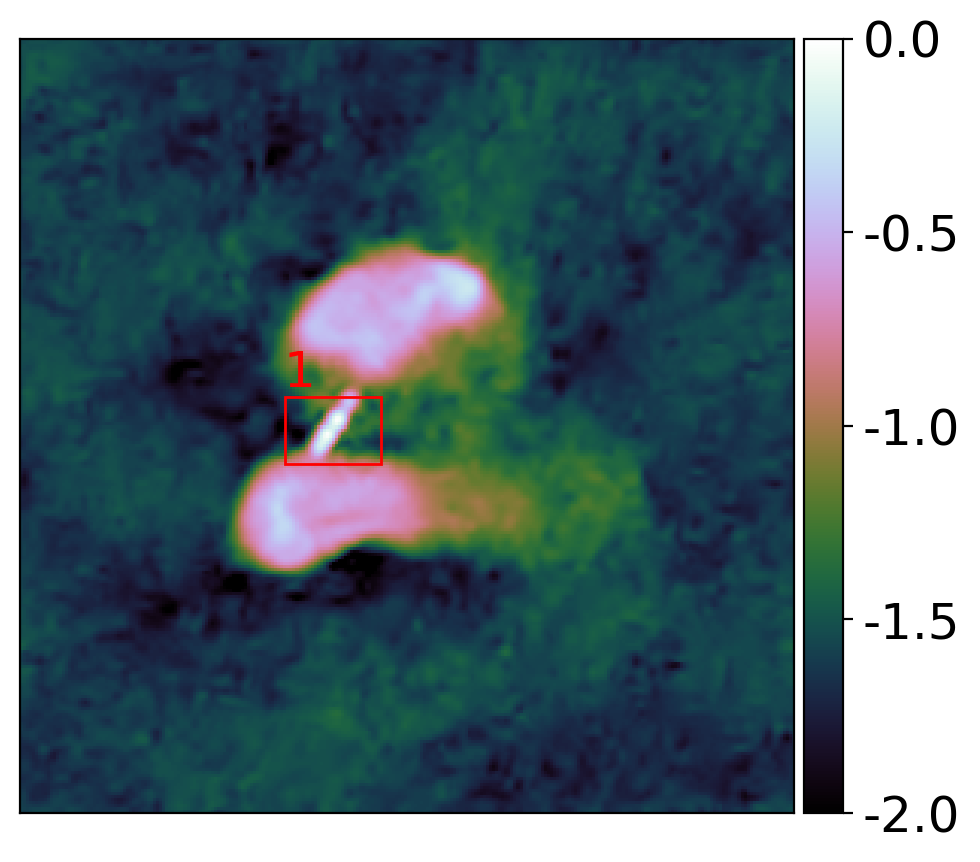

[GD] 0 out of 15000 iterations, tol = 0.000371
[GD] converged in 1750 iterations


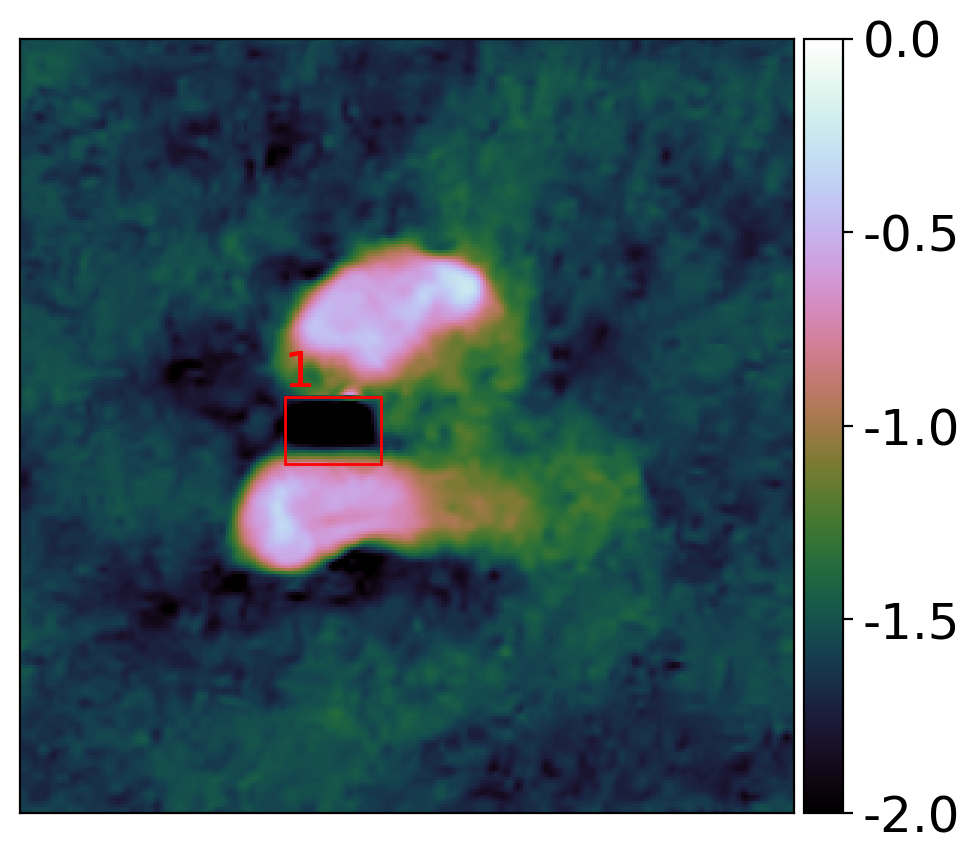

gamma_alpha:  201063.42313205294
fun(x_map).item():  133081.8456108639
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 : Inpainted area nonremovable! (Reject H0)
3c288 _gamma_alpha:  201063.42313205294
3c288 _potential:  334786.8157976295
3c288 -MAP_potential:  133081.8456108639
3c288 : Cannot conclude if blurred structure is physical! (Cannot reject H0)
3c288 _gamma_alpha:  201063.42313205294
3c288 _potential_blurring:  194217.85821593652
3c288 -MAP_potential:  133081.8456108639


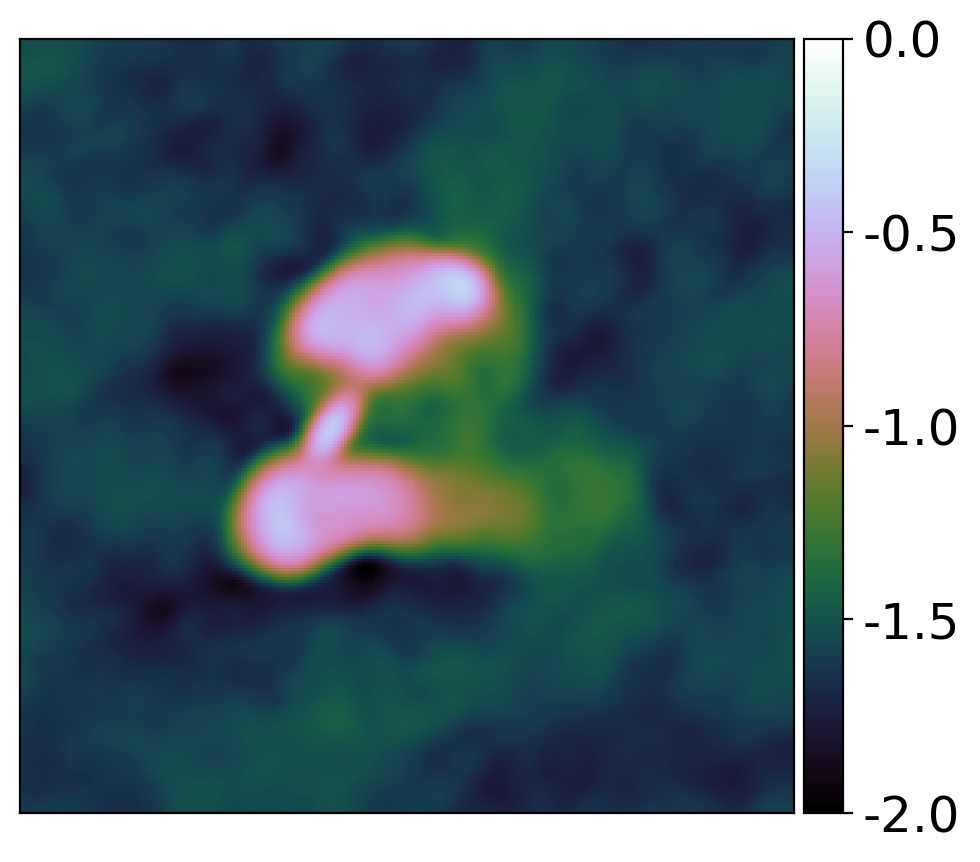

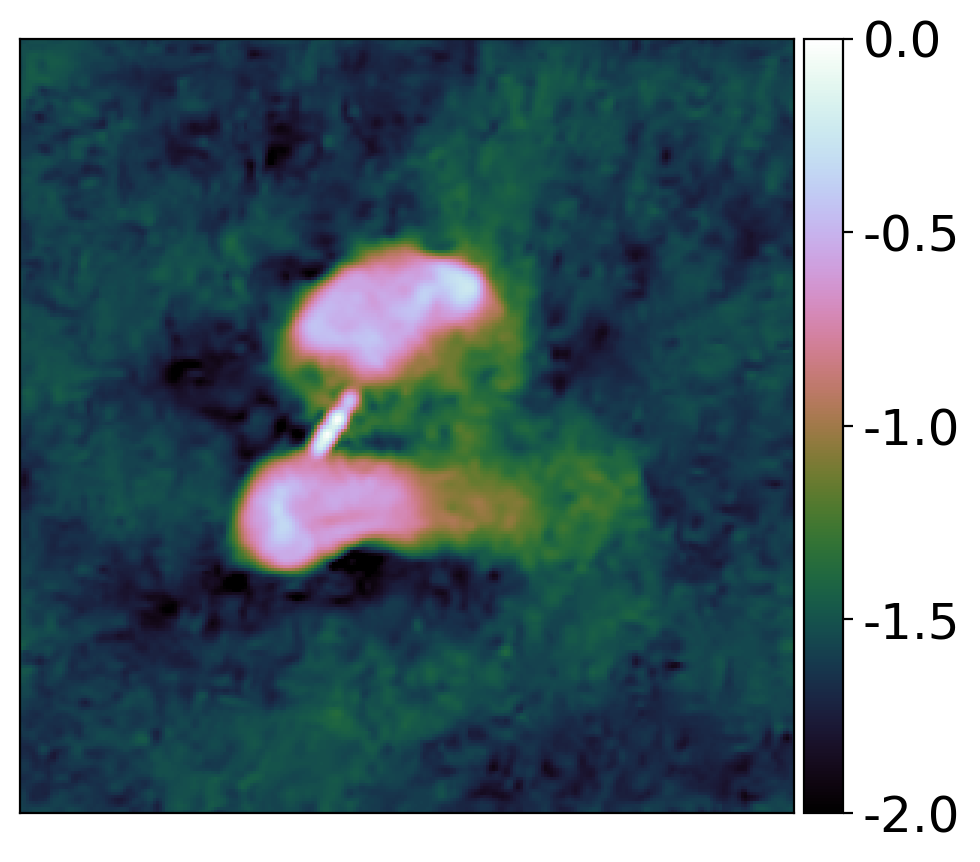

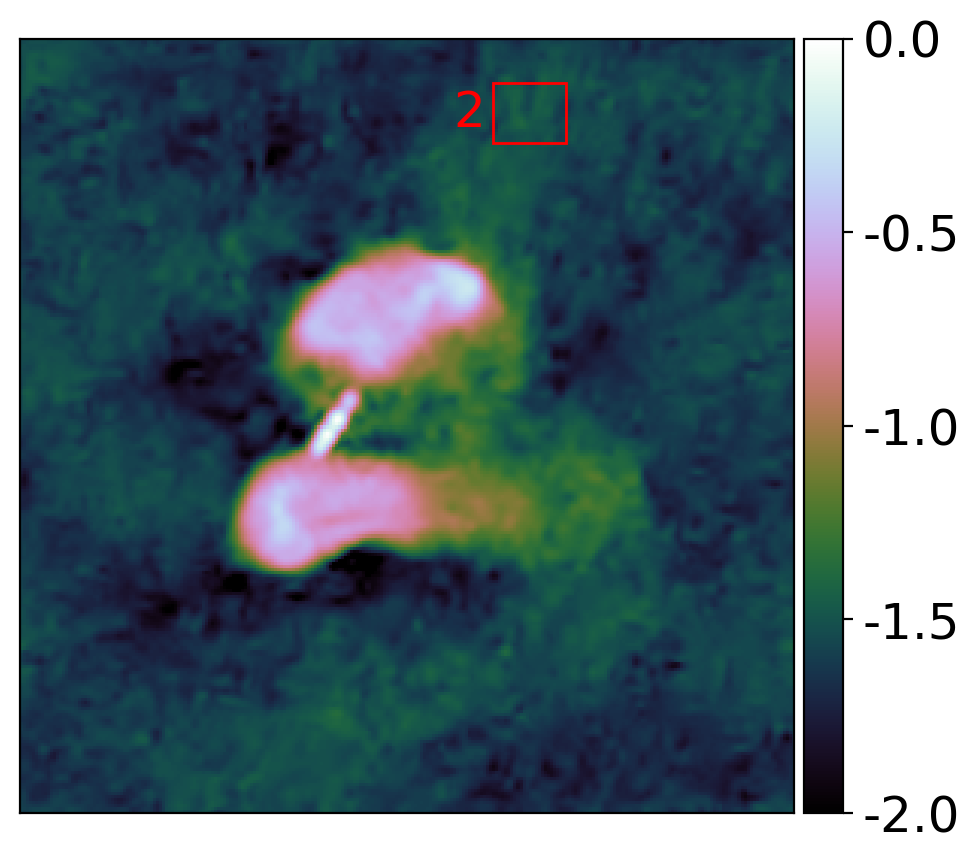

[GD] 0 out of 15000 iterations, tol = 0.000300
[GD] converged in 392 iterations


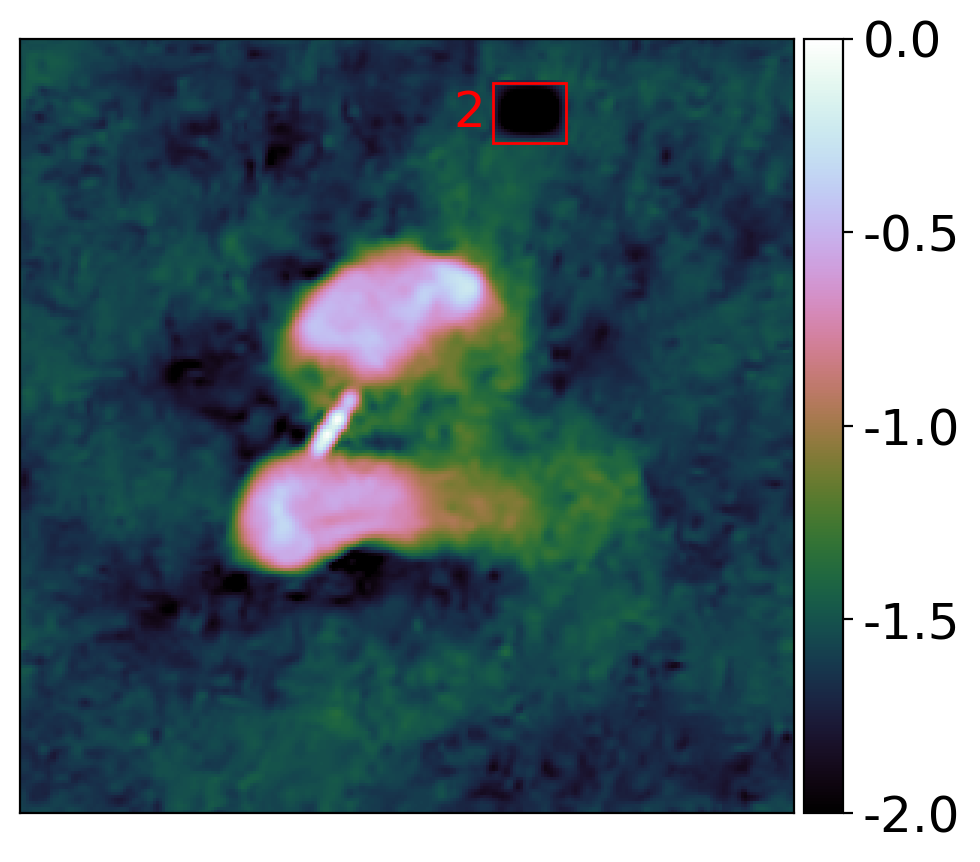

gamma_alpha:  201063.42313205294
fun(x_map).item():  133081.8456108639
tau_alpha*np.sqrt(N) + N:  67981.57752118903
3c288 : Inpainted area removable! (Cannot reject H0)
3c288 _gamma_alpha:  201063.42313205294
3c288 _potential:  134829.3225808296
3c288 -MAP_potential:  133081.8456108639
3c288 : Cannot conclude if blurred structure is physical! (Cannot reject H0)
3c288 _gamma_alpha:  201063.42313205294
3c288 _potential_blurring:  194217.85821593652
3c288 -MAP_potential:  133081.8456108639


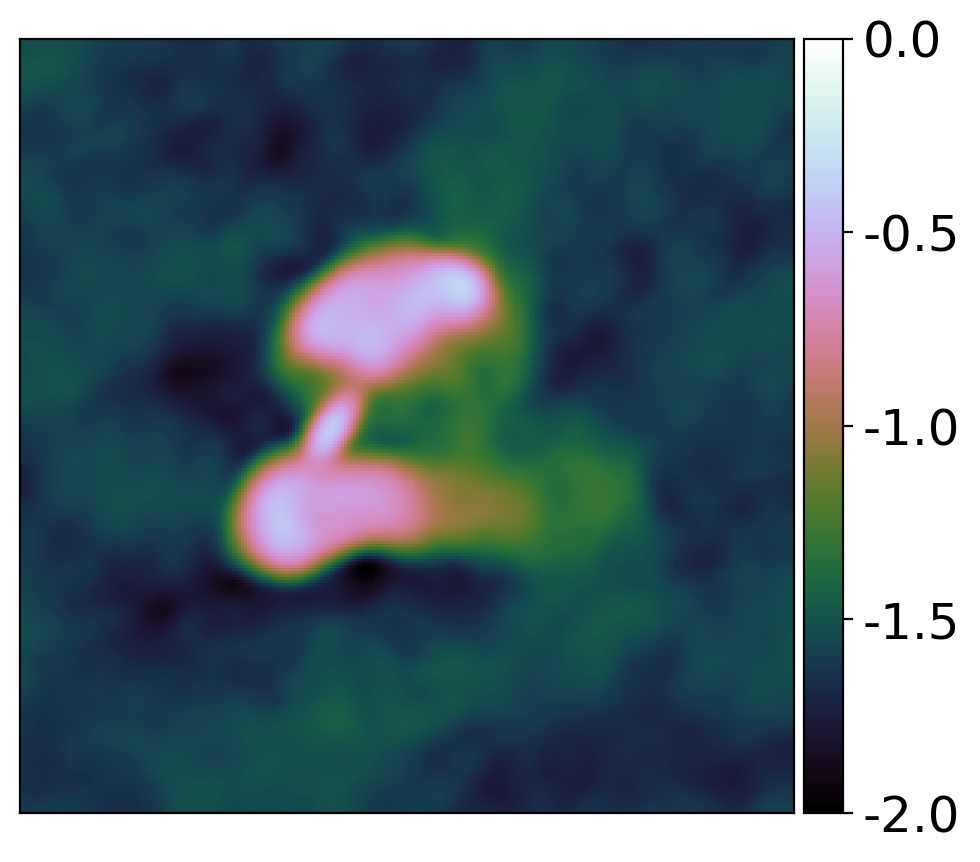

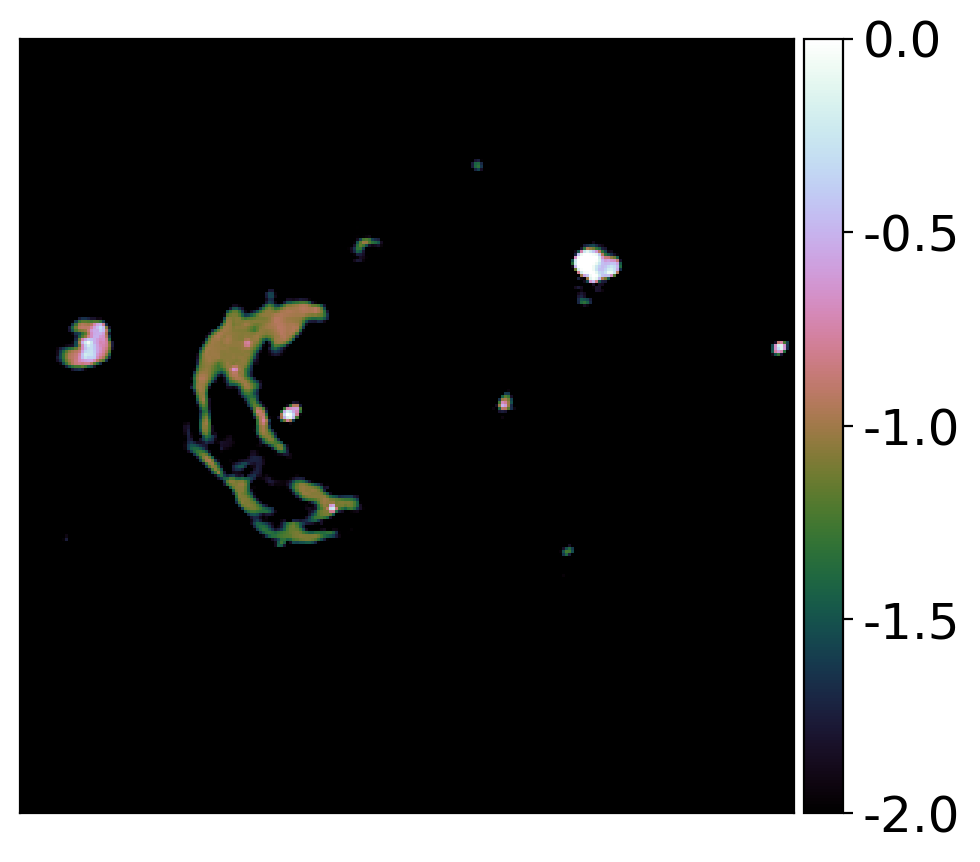

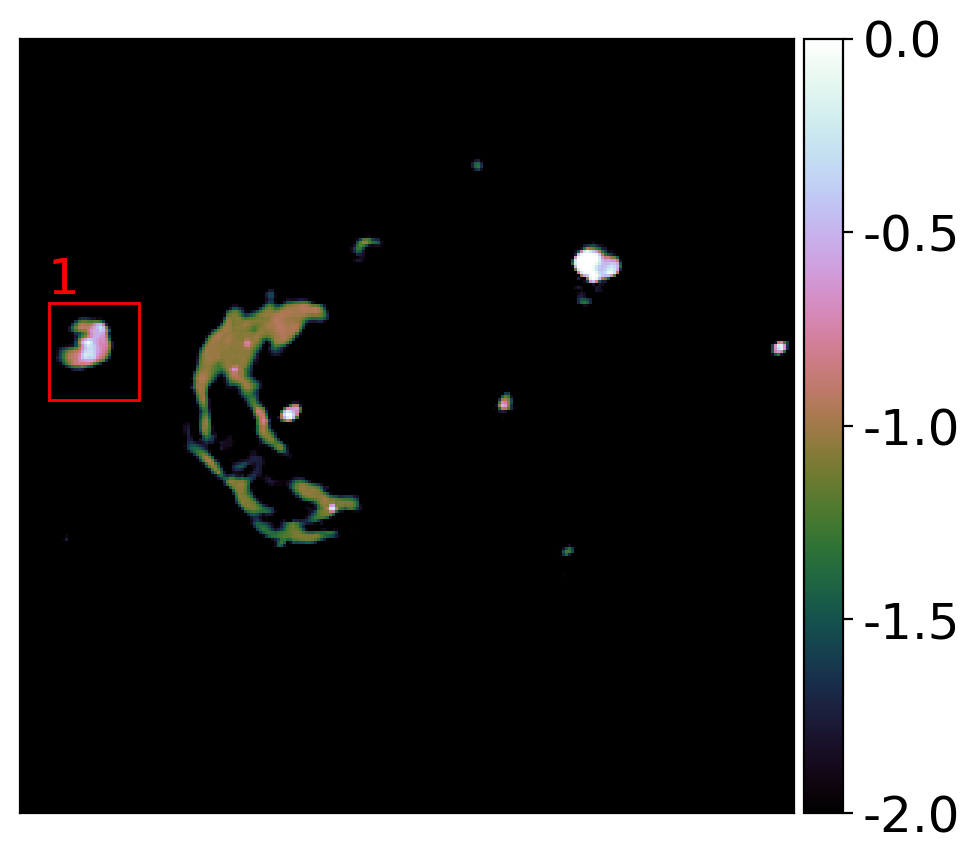

[GD] 0 out of 15000 iterations, tol = 0.000067
[GD] converged in 36 iterations


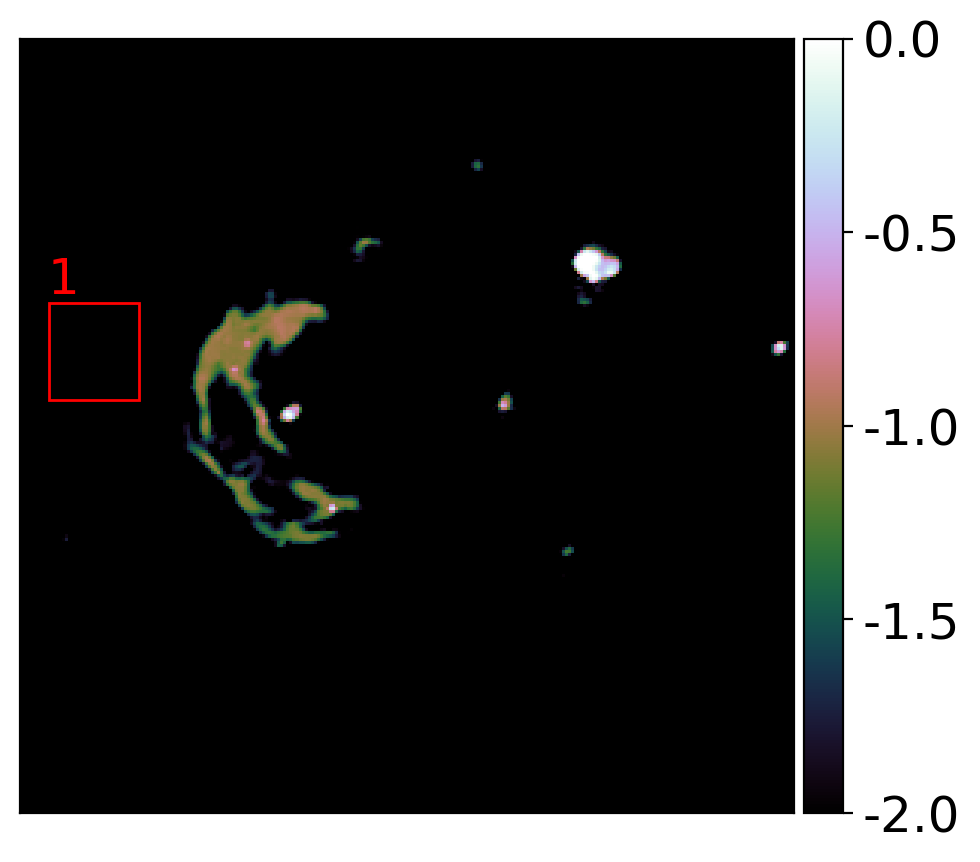

gamma_alpha:  109625.17622862986
fun(x_map).item():  41643.59870744083
tau_alpha*np.sqrt(N) + N:  67981.57752118903
W28 : Inpainted area nonremovable! (Reject H0)
W28 _gamma_alpha:  109625.17622862986
W28 _potential:  492956.07752118714
W28 -MAP_potential:  41643.59870744083
W28 : Blurred structure is physical! (Reject H0)
W28 _gamma_alpha:  109625.17622862986
W28 _potential_blurring:  852238.912907154
W28 -MAP_potential:  41643.59870744083


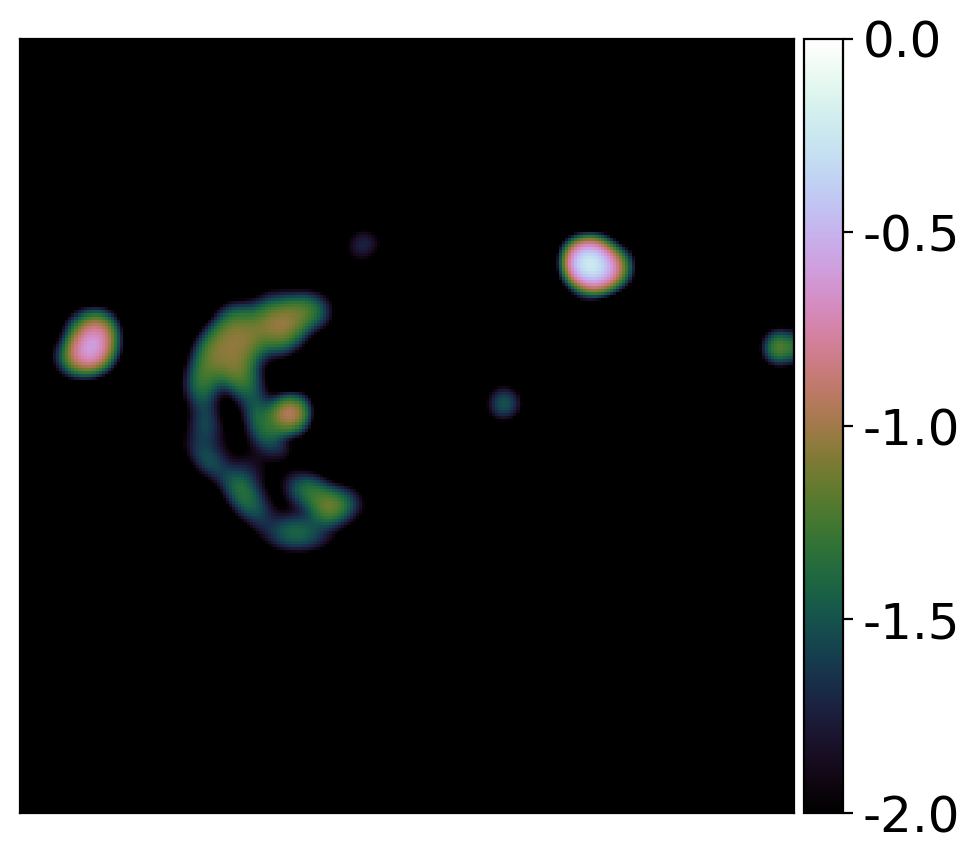

In [16]:
for it_img in range(len(img_name_list)):
    img_name = img_name_list[it_img]
    map_vars_path = map_vars_path_arr[it_img]
    samp_vars_path = samp_vars_path_arr[it_img]
    vmin_log = vmin_log_arr[it_img]

    text_pos = text_pos_arr[it_img]
    textstr = text_str_arr[it_img]
    saving_text_str = saving_text_str_arr[it_img]

    # Load variables
    map_vars = np.load(map_vars_path, allow_pickle=True)[()]
    samp_vars = np.load(samp_vars_path, allow_pickle=True)[()]

    # Load image and mask
    img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

    # Define my torch types
    myType = torch.float64
    myComplexType = torch.complex128

    # Aliases
    x = img
    ground_truth = img
    # Prepare inputs and functions
    torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
        (1, 1) + img.shape
    )
    phi = qai.operators.MaskedFourier_torch(
        shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
    )
    y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

    # Define X Cai noise level
    eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
    sigma = eff_sigma * np.sqrt(2)

    # Generate noise
    rng = np.random.default_rng(seed=0)
    n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
    n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
    # Add noise
    y[y != 0] += n_re + 1.0j * n_im

    # Observation
    torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
        (1,) + img.shape
    )
    x_init = torch.abs(phi.adj_op(torch_y))

    # Define the wavelet dict
    # Define the l1 norm with dict psi
    psi = qai.operators.DictionaryWv_torch(wavs_list, levels, shape=x_init.shape)
    h = qai.operators.L1Norm_torch(1.0, psi, op_to_coeffs=True)
    # Prior parameter
    h.gamma = reg_param

    # %%
    # Define the likelihood
    g = qai.operators.L2Norm_torch(
        sigma=sigma,
        data=torch_y,
        Phi=phi,
    )
    # Lipschitz constant computed automatically by g, stored in g.beta

    # Define real prox
    f = qai.operators.RealProx_torch()

    # Extract variables
    x_gt = samp_vars["X_ground_truth"]
    x_dirty = samp_vars["X_dirty"]
    x_map = samp_vars["X_MAP"]
    x_mmse = samp_vars["X_MMSE"]

    # Inpainting
    # Load mask details
    pysiscal = pysiscal_list[it_img]
    mask_x, mask_y = qai.helpers.get_hypothesis_test_mask(img_name, pysiscal)
    # Prepare mask
    np_mask_inpainting = np.zeros((img.shape[0], img.shape[1]))
    np_mask_inpainting[mask_x[0] : mask_x[1], mask_y[0] : mask_y[1]] = 1
    # Prepare inpaint image
    inpaint_img = np.copy(x_map)
    inpaint_img[np_mask_inpainting.astype(bool)] = 0

    mask_inpainting = to_tensor(np_mask_inpainting)
    x_init_imp = to_tensor(inpaint_img)

    # Define rectangle coordinates
    rect_anchor_xy = (mask_y[0], mask_x[0])
    rect_width = mask_y[1] - mask_y[0]
    rect_height = mask_x[1] - mask_x[0]
    # Define text attributes
    font = {
        "color": "red",
        "weight": "normal",
        "size": 18,
    }

    fig = plt.figure(figsize=(5, 5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(x_map)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([])
    axs.set_xticks([])
    plt.tight_layout()
    if save_results:
        plt.savefig(
            "{:s}{:s}{:s}{:s}{:s}{:s}".format(
                save_dir,
                img_name,
                model_prefix,
                "_region_",
                saving_text_str,
                "-MAP_image.pdf",
            ),
            bbox_inches="tight",
            dpi=200,
        )
    plt.show()

    fig = plt.figure(figsize=(5, 5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(np.log10(np.abs(x_map)), cmap=cmap, vmin=vmin_log, vmax=0)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([])
    axs.set_xticks([])
    # Create a Rectangle patch
    rect = patches.Rectangle(
        rect_anchor_xy,
        rect_width,
        rect_height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    axs.add_patch(rect)
    axs.text(
        rect_anchor_xy[0] / x_map.shape[1] + text_pos[0],
        1 - rect_anchor_xy[1] / x_map.shape[0] + text_pos[1],
        textstr,
        transform=axs.transAxes,
        fontdict=font,
        verticalalignment="top",
    )
    plt.tight_layout()
    if save_results:
        plt.savefig(
            "{:s}{:s}{:s}{:s}{:s}{:s}".format(
                save_dir,
                img_name,
                model_prefix,
                "_region_",
                saving_text_str,
                "-MAP_image_inpaintedRegion.pdf",
            ),
            bbox_inches="tight",
            dpi=200,
        )
    plt.show()

    # To tensor
    x_map_torch = to_tensor(x_map)

    # Compute stepsize
    alpha = 0.98 / g.beta

    # initialization
    x_hat = torch.clone(x_init_imp)
    z = torch.clone(x_init_imp)
    t = 1

    # Set subtraction operation
    _op_sub = lambda _x1, _x2: _x1 - _x2
    if h.num_wavs > 0:
        op_sub = partial(h._op_to_two_coeffs, op=_op_sub)
    # Set parameter
    tau = alpha

    for it_2 in range(inptaint_options["iter"]):
        x_hat_old = torch.clone(x_hat)

        # backward step
        u = h.dir_op(x_hat)
        u2 = h.dir_op(torch.clone(x_hat))
        x_hat = x_hat + h.adj_op(op_sub(h.prox(u, tau), u2))
        # Apply constraint
        x_hat = f.prox(x_hat)

        x_hat = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (
            1.0 - mask_inpainting
        )

        t_old = t
        t = 0.5 * (1 + math.sqrt(1 + 4 * t**2))
        z = x_hat + (t_old - 1) / t * (x_hat - x_hat_old)

        # relative change of norm for terminating
        res = (torch.norm(x_hat_old - x_hat) / torch.norm(x_hat_old)).item()

        if res < inptaint_options["tol"]:
            print("[GD] converged in %d iterations" % (it_2))
            break

        if it_2 % inptaint_options["update_iter"] == 0:
            print(
                "[GD] %d out of %d iterations, tol = %f"
                % (
                    it_2,
                    inptaint_options["iter"],
                    res,
                )
            )

    x_map_torch = to_tensor(x_map)

    # Generate surrogate impainted img
    surrogate_img = torch.clone(x_hat) * mask_inpainting + torch.clone(x_map_torch) * (
        1.0 - mask_inpainting
    )

    imp_surrogate = to_numpy(torch.clone(surrogate_img))

    # Define rectangle coordinates
    rect_anchor_xy = (mask_y[0], mask_x[0])
    rect_width = mask_y[1] - mask_y[0]
    rect_height = mask_x[1] - mask_x[0]
    # Define text attributes
    font = {
        "color": "red",
        "weight": "normal",
        "size": 18,
    }

    fig = plt.figure(figsize=(5, 5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(
        np.log10(np.abs(imp_surrogate)), cmap=cmap, vmin=vmin_log, vmax=0
    )
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([])
    axs.set_xticks([])

    # Create a Rectangle patch
    rect = patches.Rectangle(
        rect_anchor_xy,
        rect_width,
        rect_height,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # Add the patch to the Axes
    axs.add_patch(rect)
    axs.text(
        rect_anchor_xy[0] / x_map.shape[1] + text_pos[0],
        1 - rect_anchor_xy[1] / x_map.shape[0] + text_pos[1],
        textstr,
        transform=axs.transAxes,
        fontdict=font,
        verticalalignment="top",
    )
    plt.tight_layout()
    if save_results:
        plt.savefig(
            "{:s}{:s}{:s}{:s}{:s}{:s}".format(
                save_dir,
                img_name,
                model_prefix,
                "_region_",
                saving_text_str,
                "-inpaintedSurrogate_maskRegion.pdf",
            ),
            bbox_inches="tight",
            dpi=200,
        )
    plt.show()

    # function handles for the hypothesis test

    # Evaluation of the potentials
    # Prior potential
    prior_fun = lambda _x: h._fun_coeffs(h.dir_op(_x))
    # Posterior potential
    fun = lambda _x: g.fun(_x) + prior_fun(_x)
    # Evaluation of the potential in numpy
    fun_np = lambda _x: fun(to_tensor(_x, dtype=myType)).item()

    # Compute HPD region bound
    N = x_map.size
    tau_alpha = np.sqrt(16 * np.log(3 / alpha_prob))
    gamma_alpha = fun(x_map_torch).item() + tau_alpha * np.sqrt(N) + N

    print("gamma_alpha: ", gamma_alpha)
    print("fun(x_map).item(): ", fun(x_map_torch).item())
    print("tau_alpha*np.sqrt(N) + N: ", tau_alpha * np.sqrt(N) + N)

    # Compute potential
    map_potential = fun(x_map_torch).item()
    potential = fun(surrogate_img).item()

    # Decompose potentials
    map_likelihood_potential = g.fun(x_map_torch).item()
    map_prior_potential = prior_fun(x_map_torch).item()
    surrogate_likelihood_potential = g.fun(surrogate_img).item()
    surrogate_prior_potential = prior_fun(surrogate_img).item()

    if potential > gamma_alpha:
        print(img_name, ": Inpainted area nonremovable! (Reject H0)")
        Hnot_reject = True
    else:
        print(img_name, ": Inpainted area removable! (Cannot reject H0)")
        Hnot_reject = False
    # Print values
    print(img_name, "_gamma_alpha: ", gamma_alpha)
    print(img_name, "_potential: ", potential)
    print(img_name, "-MAP_potential: ", map_potential)
    # Save values
    map_potential_list.append(map_potential)
    surrogate_potential_list.append(potential)
    gamma_alpha_list.append(gamma_alpha)
    Hnot_reject_list.append(Hnot_reject)
    # Save decomposed potentials
    likelihood_map_potential_list.append(map_likelihood_potential)
    prior_map_potential_list.append(map_prior_potential)
    likelihood_surrogate_potential_list.append(surrogate_likelihood_potential)
    prior_surrogate_potential_list.append(surrogate_prior_potential)

    # Hypothesis test of blurred image
    gauss_blurred_im_np = sp.ndimage.gaussian_filter(
        input=np.copy(x_map),
        sigma=G_sigma,
        radius=np.int64(np.floor(2 * G_sigma)),
    )
    gauss_blurred_im = to_tensor(gauss_blurred_im_np)

    # Compute potential
    potential_blurring = fun(gauss_blurred_im).item()

    if potential_blurring > gamma_alpha:
        print(img_name, ": Blurred structure is physical! (Reject H0)")
        Hnot_reject_blurring = True
    else:
        print(
            img_name,
            ": Cannot conclude if blurred structure is physical! (Cannot reject H0)",
        )
        Hnot_reject_blurring = False
    # Print values
    print(img_name, "_gamma_alpha: ", gamma_alpha)
    print(img_name, "_potential_blurring: ", potential_blurring)
    print(img_name, "-MAP_potential: ", map_potential)
    # Save values
    potential_blurring_list.append(potential_blurring)
    Hnot_reject_blurring_list.append(Hnot_reject_blurring)

    # Plot image
    fig = plt.figure(figsize=(5, 5), dpi=200)
    axs = plt.gca()
    plt_im = axs.imshow(
        np.log10(np.abs(to_numpy(gauss_blurred_im))), cmap=cmap, vmin=vmin_log, vmax=0
    )
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plt_im, cax=cax)
    cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter("%.1f"))
    cbar.ax.tick_params(labelsize=cbar_font_size)
    axs.set_yticks([])
    axs.set_xticks([])
    plt.tight_layout()
    if save_results:
        plt.savefig(
            "{:s}{:s}{:s}{:s}{:.2f}{:s}".format(
                save_dir,
                img_name,
                model_prefix,
                "-blurred_surrogate_image_Gsigma_",
                G_sigma,
                ".pdf",
            ),
            bbox_inches="tight",
            dpi=200,
        )
    plt.show()


params_dict = {
    "model_prefix": model_prefix,
    "inptaint_options": inptaint_options,
    "reg_param": reg_param,
    "wavs_list": wavs_list,
    "levels": levels,
    "G_sigma": G_sigma,
}

save_dict = {
    "params_dict": params_dict,
    "alpha_prob": alpha_prob,
    "map_potential_list": map_potential_list,
    "surrogate_potential_list": surrogate_potential_list,
    "likelihood_map_potential_list": likelihood_map_potential_list,
    "prior_map_potential_list": prior_map_potential_list,
    "likelihood_surrogate_potential_list": likelihood_surrogate_potential_list,
    "prior_surrogate_potential_list": prior_surrogate_potential_list,
    "gamma_alpha_list": gamma_alpha_list,
    "Hnot_reject_list": Hnot_reject_list,
    "potential_blurring_list": potential_blurring_list,
    "Hnot_reject_blurring_list": Hnot_reject_blurring_list,
    "map_vars_path_arr": map_vars_path_arr,
    "samp_vars_path_arr": samp_vars_path_arr,
    "img_name_list": img_name_list,
    "pysiscal_list": pysiscal_list,
    "vmin_log_arr": vmin_log_arr,
    "text_str_arr": text_str_arr,
    "text_pos_arr": text_pos_arr,
}


# Save variables
if save_results:
    try:
        save_path = "{:s}{:s}{:s}{:s}".format(
            save_dir, "hypothesisTest", model_prefix, "_vars.npy"
        )
        if os.path.isfile(save_path):
            os.remove(save_path)
        np.save(save_path, save_dict, allow_pickle=True)

    except Exception as e:
        print("Could not save vairables. Exception caught: ", e)

In [17]:
hyp_test_path = save_dir + "hypothesisTest-WAV_vars.npy"
# hyp_test_path = save_path
hyp_test_res = np.load(hyp_test_path, allow_pickle=True)[()]

# print(hyp_test_res.keys())

for it in range(len(hyp_test_res["img_name_list"])):
    print("img: ", hyp_test_res["img_name_list"][it])
    print("Hypothesis test: Blurring")
    print("Threshold: \t\t", hyp_test_res["gamma_alpha_list"][it])
    print("MAP potential: \t\t", hyp_test_res["map_potential_list"][it])
    print("Blurring potential: \t", hyp_test_res["potential_blurring_list"][it])
    print("H0 reject: \t\t", hyp_test_res["Hnot_reject_blurring_list"][it])
    print(" ")
    print("Hypothesis test: Inpainting")
    print("Threshold: \t\t", hyp_test_res["gamma_alpha_list"][it])
    print("MAP potential: \t\t", hyp_test_res["map_potential_list"][it])
    print("\tMAP likelihood pot.: \t\t", likelihood_map_potential_list[it])
    print("\tMAP prior pot.: \t\t\t", prior_map_potential_list[it])
    print(
        "\tMAP prior/likelihood ratio: \t",
        prior_map_potential_list[it] / likelihood_map_potential_list[it],
    )
    print("Surrogate potential: \t", hyp_test_res["surrogate_potential_list"][it])
    print("\tSurr. likelihood pot.: \t\t", likelihood_surrogate_potential_list[it])
    print("\tSurr. prior pot.: \t\t\t", prior_surrogate_potential_list[it])
    print(
        "\tSurr. prior/likelihood ratio: \t",
        prior_surrogate_potential_list[it] / likelihood_surrogate_potential_list[it],
    )
    print("H0 reject: \t\t", hyp_test_res["Hnot_reject_list"][it])
    print("\n")

img:  CYN
Hypothesis test: Blurring
Threshold: 		 395431.36566172657
MAP potential: 		 260900.79676342625
Blurring potential: 	 1147042.1353444462
H0 reject: 		 True
 
Hypothesis test: Inpainting
Threshold: 		 395431.36566172657
MAP potential: 		 260900.79676342625
	MAP likelihood pot.: 		 776.8280134262548
	MAP prior pot.: 			 52024.796875
	MAP prior/likelihood ratio: 	 66.97080431682808
Surrogate potential: 	 266765.0364256091
	Surr. likelihood pot.: 		 8749.152276093142
	Surr. prior pot.: 			 51612.07421875
	Surr. prior/likelihood ratio: 	 5.899094288229365
H0 reject: 		 False


img:  M31
Hypothesis test: Blurring
Threshold: 		 488723.2763275509
MAP potential: 		 420741.6988063618
Blurring potential: 	 481968.77726241667
H0 reject: 		 False
 
Hypothesis test: Inpainting
Threshold: 		 488723.2763275509
MAP potential: 		 420741.6988063618
	MAP likelihood pot.: 		 3140.542556361839
	MAP prior pot.: 			 83520.21875
	MAP prior/likelihood ratio: 	 26.594200604227435
Surrogate potential: 	